In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # matplotlib = zakladna kniznica na vytvaranie grafov
import seaborn as sns 
import json
from scipy import stats as st
from scipy.stats import norm as nr
from collections import Counter
%matplotlib inline 
sns.set()

In [2]:
personal = pd.read_csv("data\personal_train.csv")

In [3]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
Unnamed: 0       3933 non-null int64
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


# Opis a počet atribútov
V datasete personal_train máme dokopy 3933 zaznamov, pričom kazdy má 6 atribútov. Jeden z týchto atributov je poradové cislo záznamu. Predpokladáme, že tento atribút reálne využívať pri našom zadaní nebudeme, čiže bude vhodné ho z datasetu odstrániť.
* Unnamed: 0 - jedná sa o integer hodnotu reprezentujúcu index zaznamu
* name - krstné meno + priezvisko
* address - adresa
* age - integer hodnota reprezentujúca vek subjektu
* sex - pohlavie
* date_of_birth - dátum narodenia subjektu

Taktiež vidíme, že každý atribút má non-null hodnotu vo všetkých 3933 záznamoch.

In [4]:
personal.describe()

,Unnamed: 0,age
count,3933.000000,3933.000000
mean,1966.000000,51.816934
std,1135.503633,11.814803
min,0.000000,-1.000000
25%,983.000000,44.000000
50%,1966.000000,52.000000
75%,2949.000000,60.000000
max,3932.000000,113.000000


# Zaujimavé atribúty
Pre naše zadanie zaujimave hodnoty z datasetu personal_train môžu byť vek a pohlavie subjektov. Môžeme zistovať, či existuje nejaká závislosť medzi vekom | pohlavím a výskytom cukrovky. Vek môžeme teoreticky overovať pomocou dátumu narodenia, čiže pri prípadnom výskyte nekorektných vekov (záporne cisla alebo priveľké čísla) ich možno dokážeme opraviť pomocou dátumu narodenia. V situácii, že sa vek a dátum narodenia líšia však nedokážeme určiť, ktorý z týchto atribútov je korektný. Vtedy bude asi potrebné prispôsobiť jeden druhému náhodne, resp. si určíme, že v prípade rozdielu medzi vekom a dátumom narodenia budeme brať za korektný vždy dátum narodenia. Atribúty name a address nam slúžia na spojenie s druhým datasetom (other_train.csv), keďže tieto datasety majú spoločné práve tieto 2 atribúty.

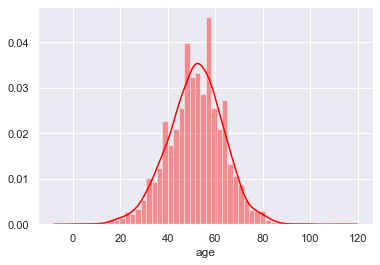

In [5]:
#personal.age.plot(kind='hist', bins=[0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115] , legend=True)
sns.distplot(personal['age'].dropna(),bins=50, color = "red")

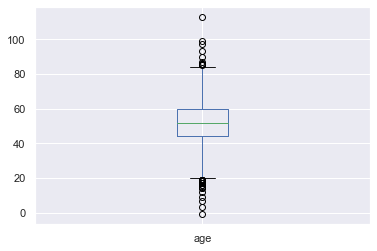

In [6]:
personal.age.plot(kind='box')

Pri veku mozme na boxplote vidiet, ze sa v datasete nachadzaju aj hodnoty veku -1 a 110+. Pri hodnote < 0 sa jedna o chybu, no este nevieme posudit ci je cely zaznam nezmyselny a je potrebne ho vyhodit. Hodnota 113 je sice velmi vychylena od zvysku, no stale sa moze jednat o korektnu hodnotu. 

In [7]:
personal[(personal.age < 0) | (personal.age > 100)]

,Unnamed: 0,name,address,age,sex,date_of_birth
1494,1494,James Raspberry,"28375 Nicole Vista\r\nValerieshire, MO 11508",-1,Female,2020-01-26
3826,3826,Clark Smith,"9472 Megan Forge\r\nNorth Selenaborough, NV 88450",113,Male,1906-07-20 00 00 00


Zobrazili sme si najkrajnejšie zaznamy, ktoré sme videli zobrazené na predchádzajúcom grafe. Vidíme, ze záznam subjektu s vekom 113 má korektný datum narodenia, čiže ho zatiaľ budeme považovať za korektný. Subjekt s vekom -1 má však nezmyselný dátum narodenia,čiže bude potrebné vyhľadať zhodujúci sa záznam v druhom datasete a zistiť, či sú aj v ňom hodnoty nezmyselné. Ak áno, záznam nám môže pokaziť náš model a radšej ho zahodíme. Stále sa však môže jednať o preklep alebo nejakú chybu v systéme.

Counter({' Male': 2651, ' Female': 1282})


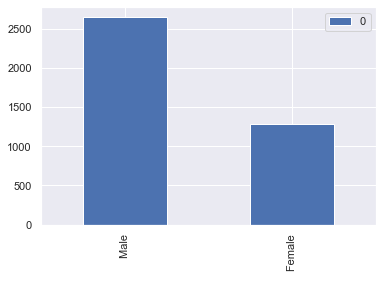

In [8]:
#TODO: graf rozdelenia pohlavi subjekov
count = Counter(personal.sex)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', legend = True)
print(count)

Na histogramoch možno vidieť, že prevažná väčšina subjektov sa nachádza vo vekovom rozpätí od 40 - 70 rokov, pričom najviac je zástupcov vo veku okolo 50 rokov. Taktiež je prevažná väčšina subjektov mužského pohlavia.

In [9]:
personal[(personal["sex"] != " Male") & (personal["sex"] != " Female")]

,Unnamed: 0,name,address,age,sex,date_of_birth


Atribút reprezentujúci pohlavie nadobúda len 2 hodnoty - Male a Female, no na ich začiatku sa nachádza zbytočný whitespace, ktorý môžme v daľšej fáze odstrániť.Netreba tu teda riešiť žiadne chýbajúce alebo vychýlené hodnoty.

# Možné chyby + návrh riešenia
V csv personal sa nachádzajú osobné údaje o jednotlivých ľudoch, t.j konkrétne ich meno, adresa, vek, pohlave a dátum narodenia
Možeme vidieť, že máme nekonzistentne zapísané dátumy narodení - raz vo formáte D/M/Y, inokedy Y-M-D a Y-M-D-T. V adresách sa nachádzaju znaky /r/n, ktore oddeľujú jednotlivé časti adries (ulice, mesto, atd...).



In [10]:
#personal = personal.drop('Unnamed: 0', axis = 1) 

In [11]:
other = pd.read_csv("data\other_train.csv")

In [12]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 23 columns):
Unnamed: 0         3983 non-null int64
name               3983 non-null object
address            3983 non-null object
kurtosis_oxygen    3969 non-null float64
occupation         3970 non-null object
marital-status     3967 non-null object
pregnant           3968 non-null object
education-num      3572 non-null float64
relationship       3969 non-null object
std_oxygen         3968 non-null float64
capital-gain       3969 non-null float64
skewness_oxygen    3964 non-null float64
education          3971 non-null object
fnlwgt             3974 non-null float64
class              3972 non-null float64
income             3971 non-null object
medical_info       3966 non-null object
native-country     3966 non-null object
capital-loss       3966 non-null float64
mean_oxygen        3972 non-null float64
hours-per-week     3967 non-null float64
race               3970 non-null object
work

# Opis atribútov
Dataset other_train.csv má 3983 záznamov a 23 atribútov.
* Unnamed: 0 - integerova hodnota obsahujuca index zaznamu
* name - krstne meno + priezvisko subjektu
* address - adresa subjektu
* kurtosis_oxygen - 
* occupation - zamestnanie
* marital-status - rodinny stav
* pregnant - 
* education-num -   
* relationship - 
* std_oxygen - 
* capital-gain - 
* skewness_oxygen - 
* education -  
* fnlwgt -   
* class - hodnoty 0 1, reprezentuju ci ma subjekt cukrovku alebo nie (jedna sa o predikovanu hodnotu)
* income - rocny prijem subjektu 
* medical_info - atribut obsahujuci dalsie 4 atributy - mean_glucose, std_glucose, kurtosis_glucose a skewness_glucose. Bude ho potrebne rozdelit ako 4 samostatne atributy
* native-country - rodna krajina
* capital-loss - 
* mean_oxygen - 
* hours-per-week - počet odpracovaných hodin týždenne
* race -  rasa subjektu
* workclass - vykytuju sa hodnoty NaN a ???

In [13]:
other.describe()

,Unnamed: 0,kurtosis_oxygen,education-num,std_oxygen,capital-gain,skewness_oxygen,fnlwgt,class,capital-loss,mean_oxygen,hours-per-week
count,3983.00000,3969.000000,3572.000000,3968.000000,3969.000000,3964.000000,3974.000000,3972.000000,3966.000000,3972.000000,3967.000000
mean,1991.00000,7.423042,13.064110,31.158976,1118.833207,91.795908,190944.202063,0.255287,87.882753,18.504313,40.733552
std,1149.93739,4.846216,331.930108,22.265708,7522.515940,110.770563,103909.567546,0.436077,401.609490,34.837091,12.383999
min,0.00000,-2.597872,-1600.000000,7.370432,0.000000,-1.976976,14878.000000,0.000000,0.000000,0.213211,1.000000
25%,995.50000,3.637833,9.000000,15.064858,0.000000,12.966818,119457.750000,0.000000,0.000000,2.069189,40.000000
50%,1991.00000,7.781618,10.000000,20.579902,0.000000,68.623477,179434.500000,0.000000,0.000000,3.234532,40.000000
75%,2986.50000,10.259075,13.000000,43.229414,0.000000,126.894595,237933.000000,1.000000,0.000000,12.619983,45.000000
max,3982.00000,34.539844,1600.000000,110.642211,99999.000000,1191.000837,972354.000000,1.000000,3900.000000,217.371238,99.000000


In [14]:
#atribut medical info obsahuje hodnoty glukozy, ktore budu pravdepodobne klucove pri identifikacii cukrovky. Preto je potrebne
#tieto hodnoty reprezentovat ako samostatne atributy, cize je potrebne vytvorit nove stlpce v dataframe
other[['mean_glucose','std_glucose', 'kurtosis_glucose','skewness_glucose']] = other.medical_info.apply(lambda x: pd.Series(str(x).split(","))) 
other['mean_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')
other['std_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other['kurtosis_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other['skewness_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other = other.drop('medical_info', axis = 1)

In [15]:
other["mean_glucose"] = pd.to_numeric(other["mean_glucose"], errors = 'ignore')
other["std_glucose"] = pd.to_numeric(other["std_glucose"], errors = 'ignore')
other["kurtosis_glucose"] = pd.to_numeric(other["kurtosis_glucose"], errors = 'ignore')
other["skewness_glucose"] = pd.to_numeric(other["skewness_glucose"], errors = 'ignore')
other = other.drop('Unnamed: 0', axis = 1) #opat sa mozme zbavit stlpca indexov
other

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
0,James Wilhoit,"656 Anderson Road\r\nWest Christopherborough, ...",0.253562,Other-service,Never-married,f,1000.0,Own-child,75.716494,0.0,...,United-States,0.0,111.122910,40.0,White,Private,36.468750,39.272871,3.736451,14.914645
1,Carey Trowbridge,"581 Amanda Turnpike Suite 551\r\nNew April, CT...",9.595103,Transport-moving,Never-married,f,13.0,Not-in-family,19.598770,0.0,...,United-States,0.0,2.153846,30.0,White,Private,101.007812,41.561606,0.247111,0.527799
2,Johnathon Maier,"83956 Rivera Fall\r\nAliciastad, VA 57310",5.835402,Prof-specialty,Divorced,f,10.0,Not-in-family,23.907751,0.0,...,United-States,0.0,4.820234,48.0,White,federal-gov,134.132812,46.171956,0.008403,0.009398
3,Larry Hawkins,"865 Stephanie Overpass\r\nHillbury, TN 13782",2.105287,Craft-repair,Married-civ-spouse,f,9.0,Husband,53.796010,0.0,...,United-States,0.0,28.642140,40.0,White,NaN,22.500000,31.253750,5.482057,32.589855
4,Oscar Driscoll,"848 Bautista Loaf Apt. 958\r\nMatthewtown, VA ...",12.012792,Prof-specialty,Married-civ-spouse,f,-1400.0,Husband,12.071025,0.0,...,United-States,1887.0,1.752508,40.0,White,Private,119.132812,52.614662,0.223922,0.228760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,Benton Ybarra,"4817 Daniel Bridge Apt. 186\r\nChristineside, ...",11.959503,Sales,Married-civ-spouse,f,10.0,Husband,15.414254,0.0,...,United-States,0.0,1.483278,40.0,White,??,106.843750,41.607811,0.393023,1.154649
3979,Michael Colquitt,"94354 Thomas Extensions\r\nLake Douglasbury, M...",9.249480,Prof-specialty,Married-civ-spouse,f,1600.0,Husband,16.476213,0.0,...,United-States,1902.0,2.488294,40.0,White,State-gov,97.867188,47.408526,0.543641,0.406143
3980,James Pearl,"19716 Owens Port\r\nHensleyland, ME 35990",11.232226,Other-service,Divorced,f,9.0,Unmarried,12.260234,0.0,...,United-States,0.0,1.898829,40.0,White,Private,123.937500,38.866910,0.262160,0.717385
3981,Armand Mccoach,"8917 Evans Ferry\r\nLake Paul, SD 93388",8.392543,Protective-serv,Married-civ-spouse,f,9.0,Husband,15.339597,0.0,...,United-States,0.0,2.771739,48.0,White,State-gov,134.695312,40.103491,0.005276,0.492617


V tejto časti sme rozdelili atribút medical_info na 4 stĺpce, aby sa nám s číselnými údajmi lepšie pracovalo. Využili sme na to najprv split, následne sme prostredníctvom regexu odstránili všetky nenumerické znaky (okrem .). Následne sme konvertovali tieto hodnoty na čísla. Atribút medical_info sme z dataframu odstránili, keďže už nebude potrebný. Keďže sme odstránili atribúty Unnamed:0 a medical_info (ten sme rozdelili na 4 nové atribúty), tak máme po novom 25 atribútov (predtým ich bolo 23).

In [16]:
other.describe()

,kurtosis_oxygen,education-num,std_oxygen,capital-gain,skewness_oxygen,fnlwgt,class,capital-loss,mean_oxygen,hours-per-week,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
count,3969.000000,3572.000000,3968.000000,3969.000000,3964.000000,3974.000000,3972.000000,3966.000000,3972.000000,3967.000000,3966.000000,3966.000000,3966.000000,3966.000000
mean,7.423042,13.064110,31.158976,1118.833207,91.795908,190944.202063,0.255287,87.882753,18.504313,40.733552,101.214367,45.169444,1.012966,4.440400
std,4.846216,331.930108,22.265708,7522.515940,110.770563,103909.567546,0.436077,401.609490,34.837091,12.383999,33.597457,7.629204,1.580512,9.647700
min,-2.597872,-1600.000000,7.370432,0.000000,-1.976976,14878.000000,0.000000,0.000000,0.213211,1.000000,6.187500,25.695250,0.000154,0.000108
25%,3.637833,9.000000,15.064858,0.000000,12.966818,119457.750000,0.000000,0.000000,2.069189,40.000000,87.736328,40.128532,0.141444,0.229751
50%,7.781618,10.000000,20.579902,0.000000,68.623477,179434.500000,0.000000,0.000000,3.234532,40.000000,110.613281,45.878359,0.331311,0.526528
75%,10.259075,13.000000,43.229414,0.000000,126.894595,237933.000000,1.000000,0.000000,12.619983,45.000000,124.115234,50.369118,0.811816,2.088449
max,34.539844,1600.000000,110.642211,99999.000000,1191.000837,972354.000000,1.000000,3900.000000,217.371238,99.000000,189.734375,91.206475,8.069522,68.101622


# Zaujímavé atribúty


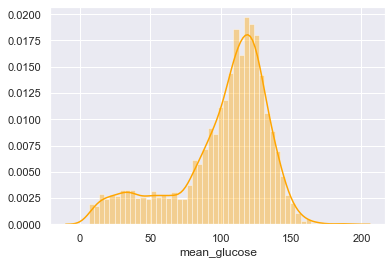

In [17]:
sns.distplot(other['mean_glucose'].dropna(),bins=50, color = "orange")

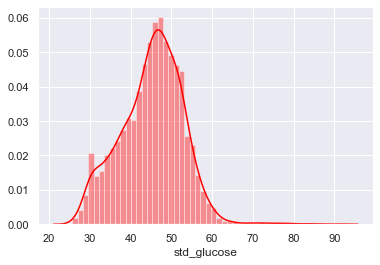

In [18]:
sns.distplot(other['std_glucose'].dropna(),bins=50, color = "red")

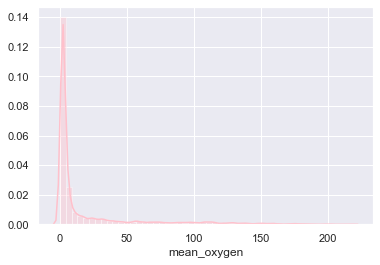

In [19]:
sns.distplot(other['mean_oxygen'].dropna(),bins=50, color = "pink")

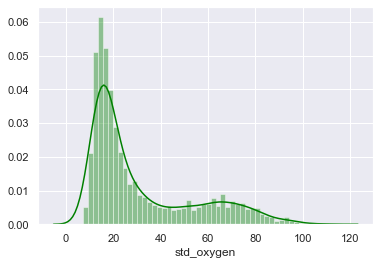

In [20]:
sns.distplot(other['std_oxygen'].dropna(),bins=50, color = "green")

In [21]:
other[(other["class"] != 1) & (other["class"] != 0)]

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
101,Jesus Barnhill,"6188 Jones Corners Suite 722\r\nMaryview, WV 6...",0.476516,Other-service,Never-married,f,-900.0,Own-child,93.174313,0.0,...,Puerto-Rico,0.0,86.353679,40.0,White,NaN,63.695312,31.297354,2.988502,15.509307
896,Rusty Thornton,036 Johnson Wells Suite 764\r\nEast Theresavil...,6.300527,Other-service,Married-civ-spouse,f,10.0,Husband,NaN,NaN,...,United-States,0.0,4.484114,40.0,White,NaN,156.046875,60.136935,0.320961,0.632663
991,Steven Coon,"5396 Kramer Common Apt. 129\r\nBlackburnshire,...",13.554053,Adm-clerical,Divorced,F,9.0,Unmarried,14.065352,0.0,...,United-States,0.0,1.348662,35.0,NaN,Private,112.062500,46.455077,0.293543,0.156486
1062,Larry Frazier,"3383 Elizabeth Courts\r\nNew Chaseview, SD 21291",9.218707,Exec-managerial,Married-civ-spouse,f,13.0,Husband,16.987123,NaN,...,United-States,0.0,2.142977,50.0,White,Private,114.070312,49.162864,0.244839,0.190308
1216,Thomas Taylor,"78667 Hernandez Mount\r\nClarkborough, WA 22409",-1.785377,NaN,Divorced,f,12.0,NaN,59.737720,4101.0,...,United-States,NaN,176.119565,40.0,White,Private,44.867188,45.693334,2.888739,8.810673
1680,Henry Glenn,6345 Deborah Keys Suite 890\r\nNorth Christoph...,NaN,Exec-managerial,NaN,f,13.0,Unmarried,16.329097,0.0,...,United-States,0.0,2.720736,50.0,White,private,NaN,NaN,NaN,NaN
1841,Freddie Mederios,"5604 Kara Plains Suite 644\r\nEast Timview, HI...",3.993995,Sales,Never-married,f,9.0,Own-child,42.661566,0.0,...,United-States,0.0,12.502508,40.0,White,Private,76.054688,60.412942,1.432917,0.936654
1886,Greg Spivey,"756 Ramos Canyon\r\nLake Scottview, NH 28478",4.322444,NaN,Married-civ-spouse,NaN,11.0,Husband,43.980061,0.0,...,United-States,0.0,10.596154,40.0,NaN,Private,NaN,NaN,NaN,NaN
2602,Stacy Harriott,"116 Rebecca Turnpike Apt. 663\r\nSimsland, NC ...",10.049017,Sales,Divorced,f,9.0,NaN,16.740221,0.0,...,United-States,0.0,2.225753,NaN,White,NaN,122.546875,56.703568,0.067255,0.609780
3526,Walter Smith,"00546 Stephanie Course\r\nEast Bryanhaven, KS ...",7.337484,Prof-specialty,NaN,f,13.0,Unmarried,21.531941,0.0,...,United-States,0.0,3.510033,40.0,White,private,106.945312,47.051220,0.153808,0.336252


V niektorych zaznamoch nemáme zapísane, či má pacient cukrovku alebo nie. Tieto záznamy sú pre naše zadanie v podstate zbytočné, pretože neobsahujú predikovanú hodnotu. Môžeme si však zatiaľ ponechať tie, ktoré majú ostatné atribúty v poriadku. Môžu nám spresniť výpočty priemeru, mediánu atď. 

Counter({0.0: 2958, 1.0: 1014})


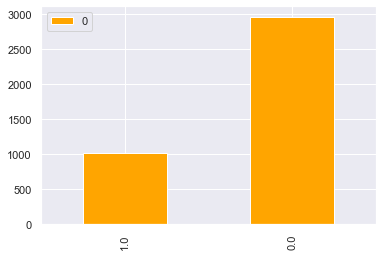

In [22]:
df = other[(other["class"] == 1) | (other["class"] == 0)]["class"]
count = Counter(df)
df = pd.DataFrame.from_dict(count, orient='index')
ax = df.plot(kind='bar', legend = True, color = "orange")
print(count)

# Porovnanie distribúcií atribútov pri ľudoch s a bez ochorenia
Teraz by sme radi zistili, ako vyzerajú hodnoty týchto atribútov pri ľudoch s cukrovkou a ľudoch bez tohoto ochorenia. Červeným sú označení ľudia, ktorým bola diagnostikovaná cukrovka, zeleným sú ľudia ktorí toto ochorenie nemajú.

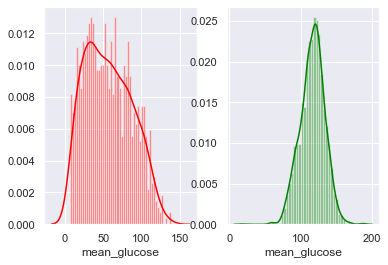

In [23]:
fig, ax=plt.subplots(1,2)
sns.distplot(other[other["class"]== 1]['mean_glucose'].dropna(),bins=50, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_glucose'].dropna(),bins=50, color = "green", ax = ax[1])

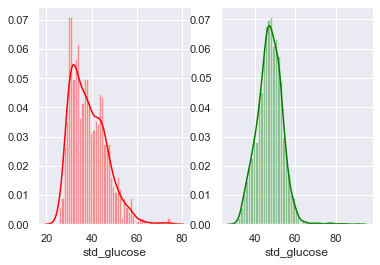

In [24]:
fig, ax=plt.subplots(1,2)
sns.distplot(other[other["class"]== 1]['std_glucose'].dropna(),bins=50, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_glucose'].dropna(),bins=50, color = "green", ax = ax[1])

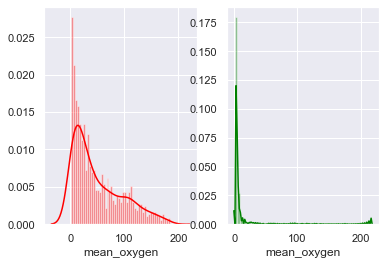

In [25]:
fig, ax=plt.subplots(1,2)
sns.distplot(other[other["class"]== 1]['mean_oxygen'].dropna(),bins=50, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['mean_oxygen'].dropna(),bins=50, color = "green", ax = ax[1])

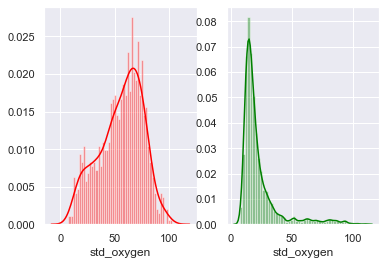

In [26]:
fig, ax=plt.subplots(1,2)
sns.distplot(other[other["class"]== 1]['std_oxygen'].dropna(),bins=50, color = "red", ax = ax[0])
sns.distplot(other[other["class"]== 0]['std_oxygen'].dropna(),bins=50, color = "green", ax = ax[1])

In [27]:
other.corr()["mean_oxygen"]

kurtosis_oxygen    -0.660076
education-num      -0.000724
std_oxygen          0.802131
capital-gain        0.004331
skewness_oxygen    -0.393819
fnlwgt              0.010584
class               0.518284
capital-loss       -0.020016
mean_oxygen         1.000000
hours-per-week      0.023371
mean_glucose       -0.544198
std_glucose        -0.202623
kurtosis_glucose    0.614110
skewness_glucose    0.553722
Name: mean_oxygen, dtype: float64

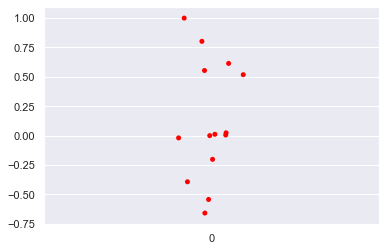

In [28]:
sns.stripplot(data=other.corr()["mean_oxygen"], color = "red")

In [29]:
other.corr()["mean_glucose"]

kurtosis_oxygen     0.472831
education-num      -0.011024
std_oxygen         -0.561198
capital-gain        0.016454
skewness_oxygen     0.304485
fnlwgt              0.024276
class              -0.775109
capital-loss        0.001869
mean_oxygen        -0.544198
hours-per-week     -0.008837
mean_glucose        1.000000
std_glucose         0.645465
kurtosis_glucose   -0.900907
skewness_glucose   -0.819927
Name: mean_glucose, dtype: float64

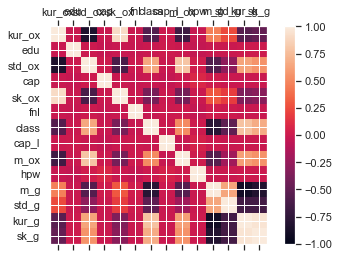

In [30]:
names = ['kur_ox', 'edu', 'std_ox', 'cap', 'sk_ox', 'fnl', 'class', 'cap_l', 'm_ox', 'hpw','m_g', 'std_g', 'kur_g', 'sk_g']
correlations = other.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [31]:
other.corr()["class"]

kurtosis_oxygen    -0.555643
education-num      -0.004584
std_oxygen          0.650266
capital-gain       -0.008443
skewness_oxygen    -0.385221
fnlwgt             -0.017244
class               1.000000
capital-loss       -0.006092
mean_oxygen         0.518284
hours-per-week      0.015091
mean_glucose       -0.775109
std_glucose        -0.500295
kurtosis_glucose    0.784912
skewness_glucose    0.675967
Name: class, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D99C967978>,
      dtype=object)

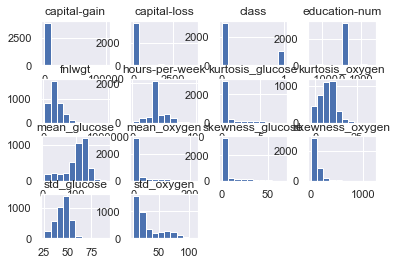

In [32]:
other.hist()

class
0.0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
1.0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
dtype: object

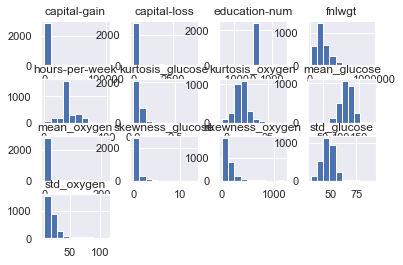

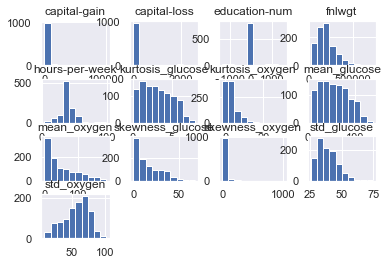

In [33]:
other.groupby('class').hist()

In [34]:
#data = pd.merge(personal, other,  how='left', left_on=['name','address'], right_on = ['name','address'])
#spojime oba dataframy do jedneho, pricom spolocne budu mat meno a adresu 
#data

# Hypotezy

* Ľudia, ktorí majú cukrovku majú nižšiu priemernú hladinu glukózy v krvi ako ľudia bez tohoto ochorenia
* 

In [37]:
personal.date_of_birth.head(50)

0              17/06/1965
1              1967-12-19
2              1954-06-27
3              1983-03-29
4              1988-11-29
5              1960-03-11
6                74-08-11
7              1957-12-17
8     1945-05-02 00 00 00
9     1962-05-03 00:00:00
10             1962-07-30
11    1954-10-11 00:00:00
12             1948-12-06
13             1974-03-17
14               73-04-28
15    1976-04-29 00 00 00
16             1977-06-17
17             1968-06-19
18    1963-03-24 00 00 00
19    1962-11-18 00:00:00
20             1950-09-11
21             1979-01-07
22             1954/10/18
23             1984-06-01
24             1957-08-02
25             1966-04-25
26             1965-07-26
27    1968-11-24 00 00 00
28             1971-10-15
29             1967/01/08
30               73-02-26
31             26/03/1966
32             1955-07-29
33             1968-08-26
34             1962-05-26
35             04/08/1965
36             1970-03-15
37             1975-06-22
38          

In [65]:
personal["datumi"] = personal["date_of_birth"].astype(str)
import time
from datetime import datetime
from time import mktime

In [68]:
for index, row in personal.iterrows():
    datetime_object = row['datumi']
    #print(datetime_object)
    
    try:
        d = time.strptime(datetime_object, '%d/%m/%Y')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y')))) 
        continue
    except:
        pass
    
    try:
        d = time.strptime(datetime_object, '%Y-%m-%d')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y'))))
        continue
    except:
        pass
    
    try:
        d = time.strptime(datetime_object, '%y-%m-%d')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y'))))
        continue
    except:
        pass
    
    try:
        d = time.strptime(datetime_object, '%Y-%m-%d %H %M %S')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y'))))
        continue
    except:
        pass
    
    try:
        datetime_object = time.strptime(datetime_object, '%Y-%m-%d %H:%M:%S')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y'))))
        continue
    except:
        pass
    
    try:
        datetime_object = time.strptime(datetime_object, '%Y/%m/%d')
        print(datetime.fromtimestamp(mktime(d.strftime('%d/%m/%Y'))))
        continue
    except:
        pass

In [ ]:
personal.date_of_birth.head(50)